In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set geomstats background
# export GEOMSTATS_BACKEND=numpy
import os
os.environ['GEOMSTATS_BACKEND'] = 'numpy'

import numpy as np
import hyperdt.benchmarking as benchmarking
from hyperdt.product_space_DT import ProductSpace, ProductSpaceDT
from sklearn.tree import DecisionTreeClassifier

INFO: Using numpy backend


In [40]:
NUM_POINTS = 1000
NUM_CLASSES = 4
signatures = [
    # [(3, -1.)],
    # [(3, 1.)],
    # [(3, -1.), (4, -.5)],
    # [(3, -1.), (4, 1.)],
    # [(3, -1.), (4, 1.), (5, 0.)],
    # [(3, -1.), (4, -.5), (3, .5), (4, 1.)],
    # [(3, -1.), (4, -.5), (3, .5), (4, 1.), (5, 0.)],
    [(5,-1), (5,-1)],
    [(5, 1), (5, 1)],
    [(5, -1), (5, 1)],
    [(2,-1), (2,-1), (2,-1), (2,-1), (2,-1)],
    [(2, 1), (2, 1), (2, 1), (2, 1), (2, 1)],
    [(2, -1), (2, -1), (2, 0), (2, 1), (2, 1)]
    # [(10,-1)],
    # [(10, 1)],
    # [(10, 0)],
]


In [45]:
import pandas as pd
from tqdm import tqdm

results = []

for seed in tqdm(range(20)):
    rnd_seeds, psdt_scores_by_signature, dt_scores_by_signature = benchmarking.compute_scores_by_signature(
        signatures, 10, NUM_CLASSES, seed=seed, max_depth=3)
    for signature, psdt_score, dt_score in zip(signatures, psdt_scores_by_signature, dt_scores_by_signature):
        results.append({
            "seed": seed,
            "signature": signature,
            "psdt_score": psdt_score,
            "dt_score": dt_score
        })

results = pd.DataFrame(results)
results

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


,seed,signature,psdt_score,dt_score
0,0,"[(5, -1), (5, -1)]","[0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, ...","[0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, ..."
1,0,"[(5, 1), (5, 1)]","[0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, 0.5, 1.0, ...","[0.5, 0.5, 0.5, 0.0, 0.5, 1.0, 0.5, 0.5, 0.0, ..."
2,0,"[(5, -1), (5, 1)]","[0.5, 1.0, 1.0, 1.0, 0.0, 0.5, 0.5, 0.5, 1.0, ...","[0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.0, ..."
3,0,"[(2, -1), (2, -1), (2, -1), (2, -1), (2, -1)]","[0.5, 0.5, 0.0, 0.5, 1.0, 0.5, 0.5, 0.5, 1.0, ...","[0.5, 1.0, 0.0, 1.0, 0.5, 0.0, 0.5, 1.0, 0.5, ..."
4,0,"[(2, 1), (2, 1), (2, 1), (2, 1), (2, 1)]","[0.5, 0.5, 0.5, 1.0, 0.0, 0.0, 0.5, 1.0, 0.5, ...","[0.5, 0.5, 0.5, 0.5, 0.0, 1.0, 0.5, 1.0, 0.0, ..."
...,...,...,...,...
115,19,"[(5, 1), (5, 1)]","[1.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, 0.5, 0.5, ...","[0.0, 0.0, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 0.5, ..."
116,19,"[(5, -1), (5, 1)]","[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, ...","[0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, ..."
117,19,"[(2, -1), (2, -1), (2, -1), (2, -1), (2, -1)]","[1.0, 0.5, 1.0, 0.5, 0.5, 0.0, 0.5, 1.0, 0.5, ...","[0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.0, ..."
118,19,"[(2, 1), (2, 1), (2, 1), (2, 1), (2, 1)]","[0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.0, 1.0, 0.5, ...","[0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, ..."


In [38]:
# for signature, psdt_scores, dt_scores in zip(signatures, psdt_scores_by_signature, dt_scores_by_signature):
    s = []
    for component in signature:
        if component[1] < 0:
            s.append("\H{" + f"{signature[0][0]}, {-signature[0][1]}" + "}")
        elif signature[0][1] == 0:
            s.append("\E{" + f"{signature[0][0]}" + "}")
        else:
            s.append("\S{" + f"{signature[0][0]}, {signature[0][1]}" + "}")
    print("$" + " \\times ".join(s) + "$", end=" & ")
    print(f"${np.mean(dt_scores) * 100:.1f} \pm {np.std(dt_scores) / np.sqrt(len(dt_scores)) * 1.96 * 100 :.1f}$", end=" & ")
    print(f"${np.mean(psdt_scores) * 100:.1f} \pm {np.std(psdt_scores) / np.sqrt(len(psdt_scores)) * 1.96 * 100 :.1f}$", end="\\\\\n")

$\H{10, 1}$ & $96.5 \pm 2.9$ & $97.6 \pm 2.5$\\
$\S{10, 1}$ & $59.8 \pm 5.4$ & $61.8 \pm 2.7$\\
$\E{10}$ & $97.0 \pm 2.3$ & $97.5 \pm 2.5$\\


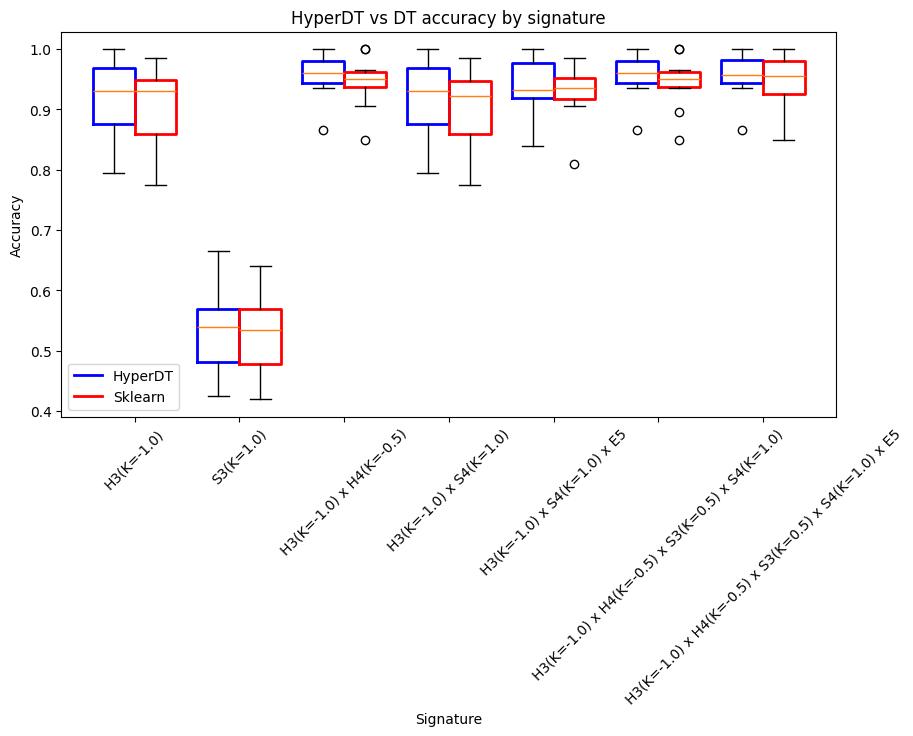

In [5]:
benchmarking.plot_boxplots(signatures, psdt_scores_by_signature, dt_scores_by_signature)

In [ ]:
# When we add dimensions and zero some out, however, we see hyperDT vastly outperforms productDT. Evidence of a bug?


for zero_dim1, zero_dim2 in [(0, 1), (0, 2), (1, 2)]:
    ps_scores = []
    dt_scores = []
    for _ in range(20):
        try:
            ps = ProductSpace(signature=[(3, -1.), (4, -.5), (3, -2.)], seed=None)
            ps.sample_clusters(1000, 4, cov_scale=0.3)

            ps.zero_out_spacelike_dims(zero_dim1)
            ps.zero_out_spacelike_dims(zero_dim2)
            ps.split_data()

            psdt = ProductSpaceDT(product_space=ps, max_depth=3)
            psdt.fit()
            psdt_score = psdt.score(ps.X_test, ps.y_test)

            X_train, X_test, y_train, y_test = ps.X_train, ps.X_test, ps.y_train, ps.y_test
            dt = DecisionTreeClassifier(max_depth=3)
            dt.fit(X_train, y_train)
            dt_score = dt.score(X_test, y_test)

            ps_scores.append(psdt_score)
            dt_scores.append(dt_score)
        except Exception as e:
            print(e)

    print(np.mean(ps_scores), np.mean(dt_scores))